# Step 0: 环境准备

In [22]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('.')
sys.path.append('./src')
sys.path.append('..')

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 本项目自定义模块
from src.data_manager import load_and_split_dataset
from src.sift_processor import extract_sift_descriptors
from src.lbp_processor import extract_lbp_descriptors
from src.bow_encoder import build_visual_dictionary, transform_to_bow
from src.feature_fusion import extract_rgb_histogram, augment_image
from src.evaluator import print_classification_metrics

# 全局参数
DATA_DIR = "../Aerial_Landscapes"        # 图像数据目录
TEST_RATIO = 0.2         # 测试集比例
SAMPLE_RATIO = 0.5       # 抽取多少比例样本
SEED = 42
N_CLUSTERS = 100         # 视觉词典大小(KMeans聚类中心数)
MAX_SAMPLES = 8000       # 用于KMeans的最大特征数
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

print("Step 0: 运行环境准备完毕！")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Step 0: 运行环境准备完毕！


# Step 1: 加载并划分数据集

In [23]:
# ===============================
# Step 1: 加载并划分数据集
# ===============================
train_paths, train_labels, test_paths, test_labels, class_names = load_and_split_dataset(
    root_folder=DATA_DIR,
    test_ratio=TEST_RATIO,
    sample_ratio=SAMPLE_RATIO,
    random_seed=SEED
)

print(f"训练集图像数: {len(train_paths)}, 测试集图像数: {len(test_paths)}")
print("类别名称:", class_names)


训练集图像数: 4800, 测试集图像数: 1200
类别名称: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


# Step 2: 封装训练 + 测试 + 评估的函数

In [24]:
# ==============================================
# Step 2: 封装训练 + 测试 + 评估的函数
# ==============================================
def train_and_evaluate_models(X_train, X_test, y_train, y_test, class_names, feature_name="SIFT"):
    """
    对输入的训练/测试特征，分别使用 4 个分类器 (SVM, RF, XGBoost, KNN) 进行训练和预测，
    输出分类报告与混淆矩阵，记录准确率、训练时间和测试时间。

    返回：一个列表，包含该特征方法下 4 个分类器的性能指标。
    """
    model_list = [
        ("SVM_RBF", SVC(kernel='rbf', C=10, gamma='scale', random_state=SEED)),
        ("RandomForest", RandomForestClassifier(n_estimators=150, random_state=SEED)),
        ("XGBoost", xgb.XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1,
                                      eval_metric='mlogloss', random_state=SEED)),
        ("KNN", KNeighborsClassifier(n_neighbors=5))
    ]

    results = []
    for model_name, clf in model_list:
        print(f"\n=== [{feature_name} - {model_name}] ===")

        # 训练
        start_train = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_train

        # 测试
        start_test = time.time()
        y_pred = clf.predict(X_test)
        test_time = time.time() - start_test

        # 打印详细报告 & 混淆矩阵
        print_classification_metrics(y_test, y_pred, class_names)

        # 记录准确率
        acc = accuracy_score(y_test, y_pred)

        # 保存结果
        results.append({
            "Feature": feature_name,
            "Model": model_name,
            "Accuracy": f"{acc*100:.2f}%",
            "Train Time (s)": f"{train_time:.3f}",
            "Test Time (s)": f"{test_time:.3f}"
        })

    return results


# Step 3: 提取SIFT特征 + BoW + 颜色直方图

In [25]:
# =============================================
# Step 3: 提取SIFT特征 + BoW + 颜色直方图
# =============================================
# 3.1 提取 SIFT 局部描述符 (训练集可使用数据增强)
sift_train_desc = extract_sift_descriptors(train_paths, augmentation_fn=augment_image)
sift_test_desc  = extract_sift_descriptors(test_paths, augmentation_fn=None)

# 3.2 建立 KMeans 视觉词典
kmeans_sift = build_visual_dictionary(sift_train_desc, cluster_count=N_CLUSTERS, max_sample=MAX_SAMPLES, seed=SEED)
print("SIFT视觉词典构建完成！")

# 3.3 将描述符转换成 BoW 向量
bow_sift_train = transform_to_bow(sift_train_desc, kmeans_sift)
bow_sift_test  = transform_to_bow(sift_test_desc, kmeans_sift)

# 3.4 提取颜色直方图
hist_sift_train = np.array([extract_rgb_histogram(p) for p in train_paths])
hist_sift_test  = np.array([extract_rgb_histogram(p) for p in test_paths])

# 3.5 拼接成一个完整特征
X_sift_train = np.hstack((bow_sift_train, hist_sift_train))
X_sift_test  = np.hstack((bow_sift_test, hist_sift_test))

# 3.6 标准化
scaler_sift = StandardScaler()
X_sift_train_scaled = scaler_sift.fit_transform(X_sift_train)
X_sift_test_scaled  = scaler_sift.transform(X_sift_test)

print("SIFT特征准备完成！")


SIFT视觉词典构建完成！
SIFT特征准备完成！


# Step 4: 提取LBP特征 + BoW + 颜色直方图

In [27]:
# =============================================
# Step 4: 提取LBP特征 + BoW + 颜色直方图
# =============================================
from src.lbp_processor import extract_lbp_descriptors

# 4.1 提取 LBP 描述符 (同样可用数据增强)
lbp_train_desc = extract_lbp_descriptors(
    train_paths,
    radius=LBP_RADIUS,
    n_points=LBP_POINTS,
    method='uniform',
    augmentation_fn=augment_image
)
lbp_test_desc = extract_lbp_descriptors(
    test_paths,
    radius=LBP_RADIUS,
    n_points=LBP_POINTS,
    method='uniform',
    augmentation_fn=None
)

# 4.2 建立 KMeans 视觉词典
kmeans_lbp = build_visual_dictionary(lbp_train_desc, cluster_count=N_CLUSTERS, max_sample=MAX_SAMPLES, seed=SEED)
print("LBP视觉词典构建完成！")

# 4.3 描述符转 BoW 向量
bow_lbp_train = transform_to_bow(lbp_train_desc, kmeans_lbp)
bow_lbp_test  = transform_to_bow(lbp_test_desc, kmeans_lbp)

# 4.4 提取颜色直方图
hist_lbp_train = np.array([extract_rgb_histogram(p) for p in train_paths])
hist_lbp_test  = np.array([extract_rgb_histogram(p) for p in test_paths])

# 4.5 拼接
X_lbp_train = np.hstack((bow_lbp_train, hist_lbp_train))
X_lbp_test  = np.hstack((bow_lbp_test, hist_lbp_test))

# 4.6 标准化
scaler_lbp = StandardScaler()
X_lbp_train_scaled = scaler_lbp.fit_transform(X_lbp_train)
X_lbp_test_scaled  = scaler_lbp.transform(X_lbp_test)

print("LBP特征准备完成！")


/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommend

LBP视觉词典构建完成！
LBP特征准备完成！


# Step 5: 分别训练4个分类器并输出对比 (SIFT vs LBP)

==== [SIFT] 4分类器训练&评估 ====

=== [SIFT - SVM_RBF] ===

分类报告：
              precision    recall  f1-score   support

 Agriculture       0.69      0.62      0.66        80
     Airport       0.69      0.60      0.64        80
       Beach       0.73      0.76      0.74        80
        City       0.80      0.59      0.68        80
      Desert       0.56      0.89      0.69        80
      Forest       0.85      0.94      0.89        80
   Grassland       0.77      0.72      0.75        80
     Highway       0.59      0.65      0.62        80
        Lake       0.63      0.45      0.53        80
    Mountain       0.83      0.86      0.85        80
     Parking       0.89      0.89      0.89        80
        Port       0.83      0.72      0.77        80
     Railway       0.64      0.72      0.68        80
 Residential       0.84      0.88      0.86        80
       River       0.58      0.54      0.56        80

    accuracy                           0.72      1200
   macro avg       0

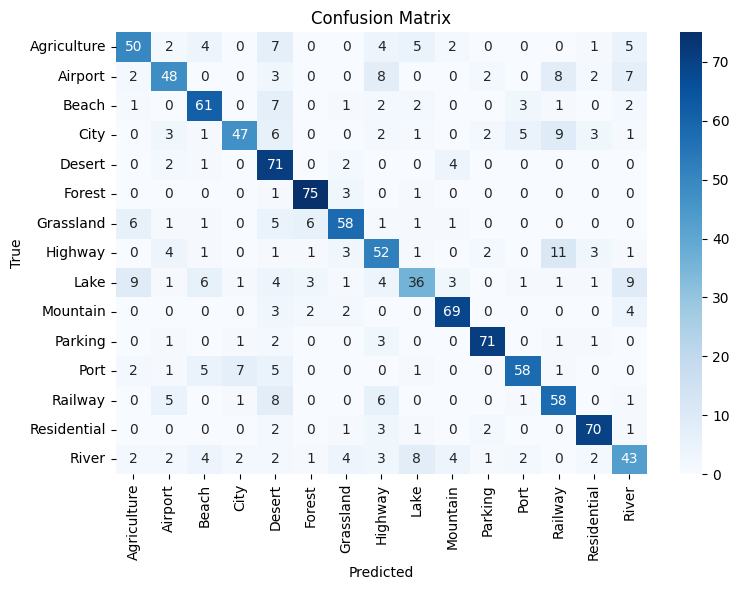


=== [SIFT - RandomForest] ===

分类报告：
              precision    recall  f1-score   support

 Agriculture       0.74      0.68      0.71        80
     Airport       0.60      0.61      0.61        80
       Beach       0.79      0.78      0.78        80
        City       0.88      0.57      0.70        80
      Desert       0.88      0.90      0.89        80
      Forest       0.75      0.99      0.85        80
   Grassland       0.83      0.78      0.80        80
     Highway       0.54      0.66      0.59        80
        Lake       0.57      0.38      0.45        80
    Mountain       0.72      0.85      0.78        80
     Parking       0.87      0.86      0.87        80
        Port       0.91      0.75      0.82        80
     Railway       0.51      0.68      0.58        80
 Residential       0.78      0.88      0.82        80
       River       0.61      0.51      0.56        80

    accuracy                           0.72      1200
   macro avg       0.73      0.72      0.7

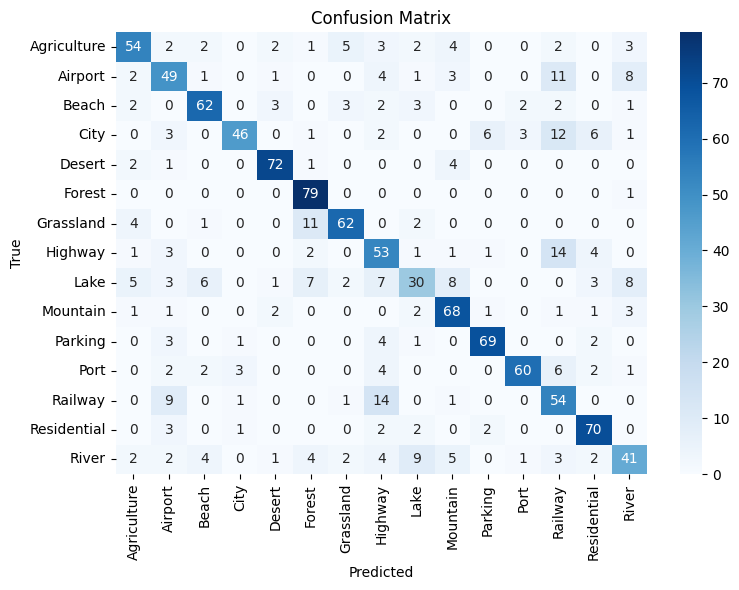


=== [SIFT - XGBoost] ===

分类报告：
              precision    recall  f1-score   support

 Agriculture       0.81      0.68      0.73        80
     Airport       0.67      0.61      0.64        80
       Beach       0.84      0.81      0.83        80
        City       0.89      0.61      0.73        80
      Desert       0.91      0.89      0.90        80
      Forest       0.87      0.99      0.92        80
   Grassland       0.92      0.86      0.89        80
     Highway       0.59      0.71      0.64        80
        Lake       0.54      0.47      0.51        80
    Mountain       0.78      0.80      0.79        80
     Parking       0.92      0.90      0.91        80
        Port       0.88      0.85      0.87        80
     Railway       0.66      0.80      0.72        80
 Residential       0.88      0.89      0.88        80
       River       0.50      0.64      0.56        80

    accuracy                           0.77      1200
   macro avg       0.78      0.77      0.77    

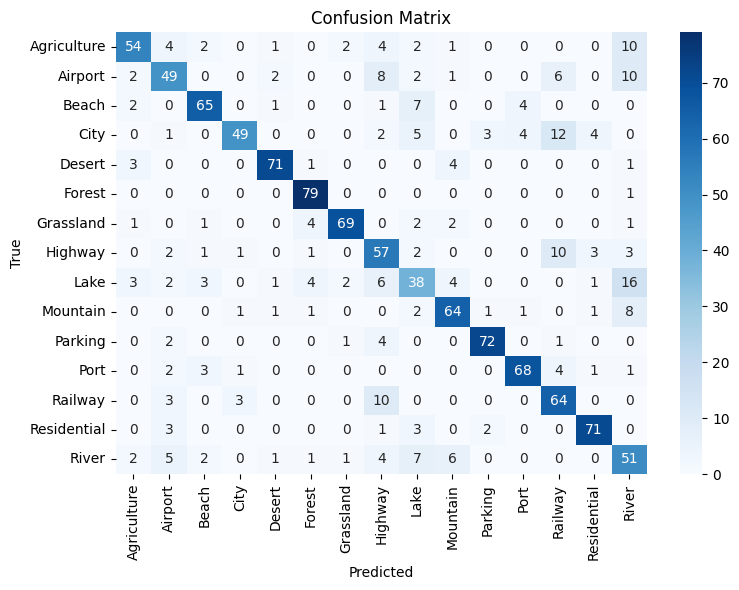


=== [SIFT - KNN] ===

分类报告：
              precision    recall  f1-score   support

 Agriculture       0.57      0.38      0.45        80
     Airport       0.44      0.39      0.41        80
       Beach       0.89      0.59      0.71        80
        City       0.56      0.71      0.63        80
      Desert       0.91      0.65      0.76        80
      Forest       0.75      0.96      0.85        80
   Grassland       0.78      0.53      0.63        80
     Highway       0.31      0.47      0.37        80
        Lake       0.50      0.19      0.27        80
    Mountain       0.64      0.79      0.70        80
     Parking       0.81      0.80      0.81        80
        Port       0.72      0.59      0.65        80
     Railway       0.46      0.71      0.56        80
 Residential       0.55      0.89      0.68        80
       River       0.43      0.33      0.37        80

    accuracy                           0.60      1200
   macro avg       0.62      0.60      0.59      12

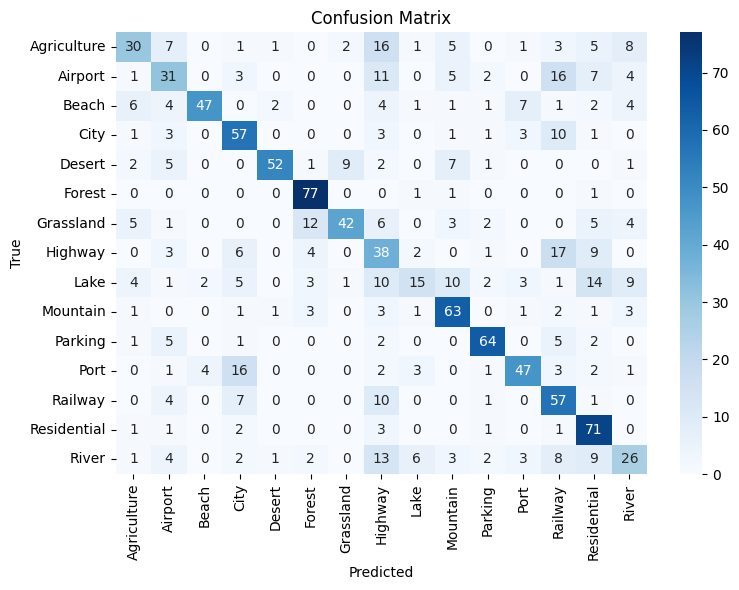

==== [LBP] 4分类器训练&评估 ====

=== [LBP - SVM_RBF] ===

分类报告：
              precision    recall  f1-score   support

 Agriculture       0.35      0.33      0.34        80
     Airport       0.52      0.29      0.37        80
       Beach       0.51      0.75      0.61        80
        City       0.60      0.38      0.46        80
      Desert       0.63      0.86      0.73        80
      Forest       0.61      0.86      0.72        80
   Grassland       0.58      0.89      0.70        80
     Highway       0.39      0.16      0.23        80
        Lake       0.80      0.41      0.55        80
    Mountain       0.53      0.53      0.53        80
     Parking       0.45      0.79      0.57        80
        Port       0.53      0.36      0.43        80
     Railway       0.37      0.35      0.36        80
 Residential       0.63      0.78      0.69        80
       River       0.51      0.28      0.36        80

    accuracy                           0.53      1200
   macro avg       0.5

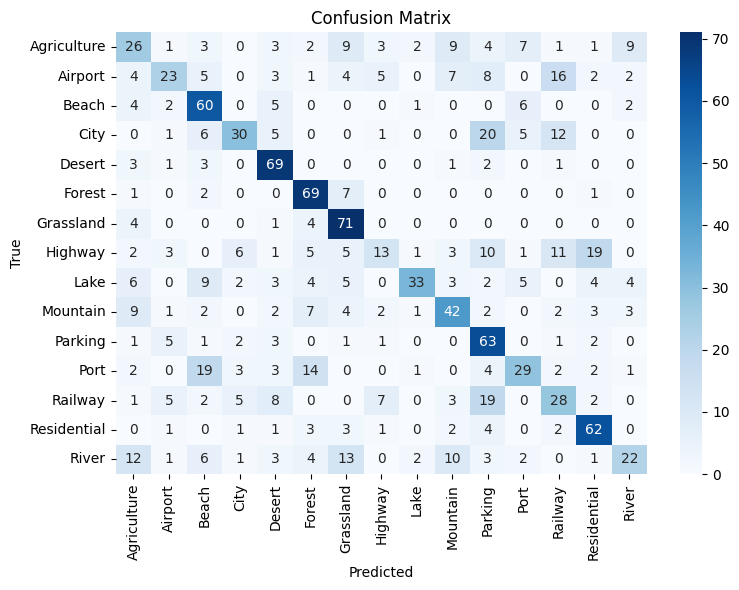


=== [LBP - RandomForest] ===

分类报告：
              precision    recall  f1-score   support

 Agriculture       0.57      0.61      0.59        80
     Airport       0.46      0.60      0.52        80
       Beach       0.72      0.72      0.72        80
        City       0.67      0.60      0.63        80
      Desert       0.87      0.91      0.89        80
      Forest       0.73      0.89      0.80        80
   Grassland       0.75      0.86      0.80        80
     Highway       0.58      0.38      0.45        80
        Lake       0.70      0.49      0.57        80
    Mountain       0.64      0.65      0.65        80
     Parking       0.77      0.81      0.79        80
        Port       0.86      0.78      0.82        80
     Railway       0.51      0.50      0.50        80
 Residential       0.72      0.86      0.78        80
       River       0.62      0.50      0.56        80

    accuracy                           0.68      1200
   macro avg       0.68      0.68      0.67

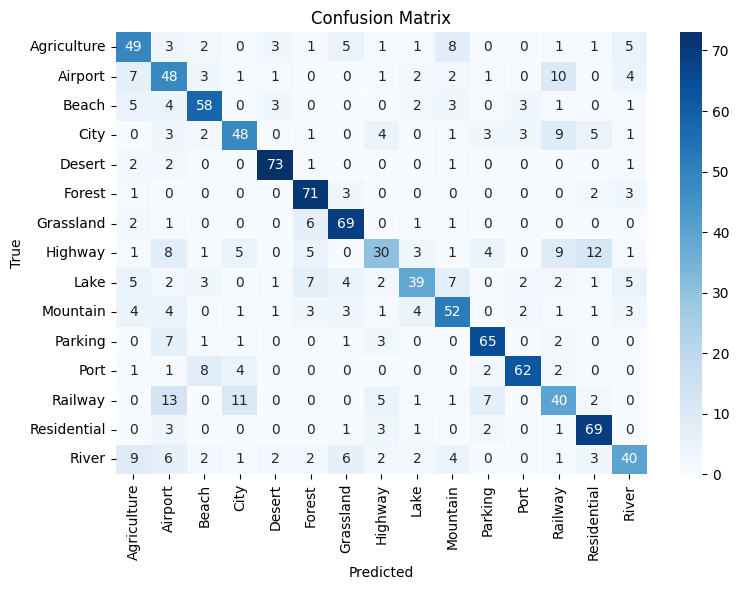


=== [LBP - XGBoost] ===

分类报告：
              precision    recall  f1-score   support

 Agriculture       0.63      0.71      0.67        80
     Airport       0.53      0.62      0.57        80
       Beach       0.74      0.76      0.75        80
        City       0.68      0.60      0.64        80
      Desert       0.94      0.90      0.92        80
      Forest       0.80      0.90      0.85        80
   Grassland       0.81      0.82      0.82        80
     Highway       0.59      0.54      0.56        80
        Lake       0.66      0.55      0.60        80
    Mountain       0.62      0.64      0.63        80
     Parking       0.84      0.82      0.83        80
        Port       0.86      0.78      0.82        80
     Railway       0.56      0.64      0.60        80
 Residential       0.87      0.85      0.86        80
       River       0.62      0.56      0.59        80

    accuracy                           0.71      1200
   macro avg       0.72      0.71      0.71     

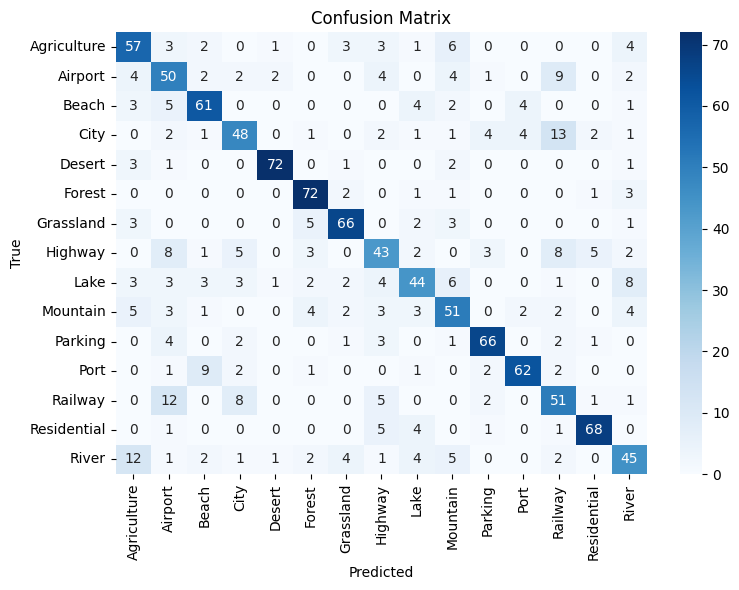


=== [LBP - KNN] ===

分类报告：
              precision    recall  f1-score   support

 Agriculture       0.19      0.19      0.19        80
     Airport       0.23      0.09      0.13        80
       Beach       0.54      0.33      0.41        80
        City       0.42      0.28      0.33        80
      Desert       0.86      0.47      0.61        80
      Forest       0.45      0.72      0.55        80
   Grassland       0.38      0.75      0.50        80
     Highway       0.15      0.10      0.12        80
        Lake       0.67      0.23      0.34        80
    Mountain       0.28      0.14      0.18        80
     Parking       0.28      0.68      0.39        80
        Port       0.45      0.25      0.32        80
     Railway       0.30      0.23      0.26        80
 Residential       0.22      0.60      0.32        80
       River       0.22      0.05      0.08        80

    accuracy                           0.34      1200
   macro avg       0.38      0.34      0.32      120

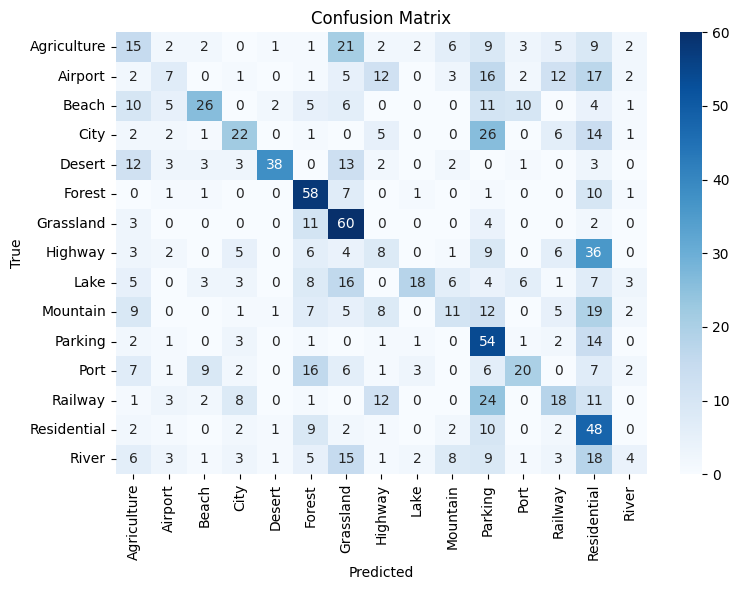

In [28]:
# ================================================
# Step 5: 分别训练4个分类器并输出对比 (SIFT vs LBP)
# ================================================
all_results = []

print("==== [SIFT] 4分类器训练&评估 ====")
results_sift = train_and_evaluate_models(
    X_train=X_sift_train_scaled,
    X_test=X_sift_test_scaled,
    y_train=train_labels,
    y_test=test_labels,
    class_names=class_names,
    feature_name="SIFT"
)
all_results.extend(results_sift)

print("==== [LBP] 4分类器训练&评估 ====")
results_lbp = train_and_evaluate_models(
    X_train=X_lbp_train_scaled,
    X_test=X_lbp_test_scaled,
    y_train=train_labels,
    y_test=test_labels,
    class_names=class_names,
    feature_name="LBP"
)
all_results.extend(results_lbp)


# Step 6: 汇总8种组合表现

In [29]:
# ================================================
# Step 6: 汇总8种组合表现
# ================================================
df_all = pd.DataFrame(all_results)
df_all


,Feature,Model,Accuracy,Train Time (s),Test Time (s)
0,SIFT,SVM_RBF,72.25%,3.472,2.349
1,SIFT,RandomForest,72.42%,6.338,0.052
2,SIFT,XGBoost,76.75%,24.854,0.015
3,SIFT,KNN,59.75%,0.005,0.060
4,LBP,SVM_RBF,53.33%,4.170,2.431
5,LBP,RandomForest,67.75%,3.159,0.056
6,LBP,XGBoost,71.33%,16.325,0.016
7,LBP,KNN,33.92%,0.005,0.056


# 可再输出 markdown 格式表格

In [31]:
print("📊 SIFT vs. LBP + 4 Classifiers 对比：")
print(df_all.to_markdown(index=False))

df_all.to_csv("sift_lbp_4classifiers_results.csv", index=False)

📊 SIFT vs. LBP + 4 Classifiers 对比：
| Feature   | Model        | Accuracy   |   Train Time (s) |   Test Time (s) |
|:----------|:-------------|:-----------|-----------------:|----------------:|
| SIFT      | SVM_RBF      | 72.25%     |            3.472 |           2.349 |
| SIFT      | RandomForest | 72.42%     |            6.338 |           0.052 |
| SIFT      | XGBoost      | 76.75%     |           24.854 |           0.015 |
| SIFT      | KNN          | 59.75%     |            0.005 |           0.06  |
| LBP       | SVM_RBF      | 53.33%     |            4.17  |           2.431 |
| LBP       | RandomForest | 67.75%     |            3.159 |           0.056 |
| LBP       | XGBoost      | 71.33%     |           16.325 |           0.016 |
| LBP       | KNN          | 33.92%     |            0.005 |           0.056 |
